In [6]:
import sys
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from shapely import  Point
from itertools import combinations
sys.path.append(os.path.abspath('../raw_to_map'))

from im_to_im import epipolar_line, load_buildings, match_points, get_overlap, find_points_in_overlap, get_true_matches, point_exists_in_dict, add_match, add_single_point, main, plot_matches


Load buildings from the raw_to_map project, and calculate the mean position of the vertices. 
The result is a dictionary where the values are mean points of buildings in the image with id given in the dict key.

In [2]:
with open('../AgderOst/settings.json') as f:
    settings = json.load(f)
with open('overlap.json') as f:
    overlap = json.load(f)
buildings = load_buildings('../AgderOst/buildings_transformed')

buildings_pt = {iid_adj: set() for iid_adj in overlap.keys()} 
for building in buildings:
    iids = set(building['corners'].keys()).intersection(buildings_pt.keys())
    if iids:
        for iid in iids:
            point = Point(np.round(np.mean(np.array(list(building['corners'][iid])), axis=0), 6))
            buildings_pt[iid].add(point)

100%|██████████| 8465/8465 [00:03<00:00, 2303.74it/s]


Loaded 8465 building objects from ../AgderOst/buildings_transformed


"overlap" is a dict where the values are ids om images that overlap with the image with id in the key. 
Below is a reduced overlap dictionary for demonstration purposes

In [3]:
limited_overlap = dict(list(overlap.items())[:5])
for id in limited_overlap:
    new_list = [i for i in limited_overlap[id] if i in limited_overlap.keys()]
    limited_overlap[id] = new_list

for v in limited_overlap.items():
    print(v)

('14583_01_001_20017', ['14583_01_002_20018', '14583_01_003_20019', '14583_01_004_20020'])
('14583_01_002_20018', ['14583_01_001_20017', '14583_01_003_20019', '14583_01_004_20020', '14583_01_005_20021'])
('14583_01_003_20019', ['14583_01_001_20017', '14583_01_002_20018', '14583_01_004_20020', '14583_01_005_20021'])
('14583_01_004_20020', ['14583_01_001_20017', '14583_01_002_20018', '14583_01_003_20019', '14583_01_005_20021'])
('14583_01_005_20021', ['14583_01_002_20018', '14583_01_003_20019', '14583_01_004_20020'])


In [4]:
matches, mult_matches = main(limited_overlap, buildings_pt, print_metrics=True, buildings_true=buildings)

20017-20018: Precision:1.0 -- Recall 0.9979 --F1: 0.9989 -- N matches: 475 -- mult match:2

20017-20019: Precision:1.0 -- Recall 1.0 --F1: 1.0 -- N matches: 227 -- mult match:0

20017-20020: Precision:1.0 -- Recall 0.9848 --F1: 0.9923 -- N matches: 130 -- mult match:2

20018-20019: Precision:1.0 -- Recall 0.9919 --F1: 0.9959 -- N matches: 244 -- mult match:0

20018-20020: Precision:1.0 -- Recall 0.9868 --F1: 0.9934 -- N matches: 149 -- mult match:2

20018-20021: Precision:1.0 -- Recall 1.0 --F1: 1.0 -- N matches: 118 -- mult match:0

20019-20020: Precision:1.0 -- Recall 1.0 --F1: 1.0 -- N matches: 357 -- mult match:0

20019-20021: Precision:1.0 -- Recall 0.9969 --F1: 0.9984 -- N matches: 323 -- mult match:0

20020-20021: Precision:1.0 -- Recall 0.9938 --F1: 0.9969 -- N matches: 483 -- mult match:0



c:\Users\sigbj\miniconda3\Lib\site-packages\rasterio\__init__.py:368: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


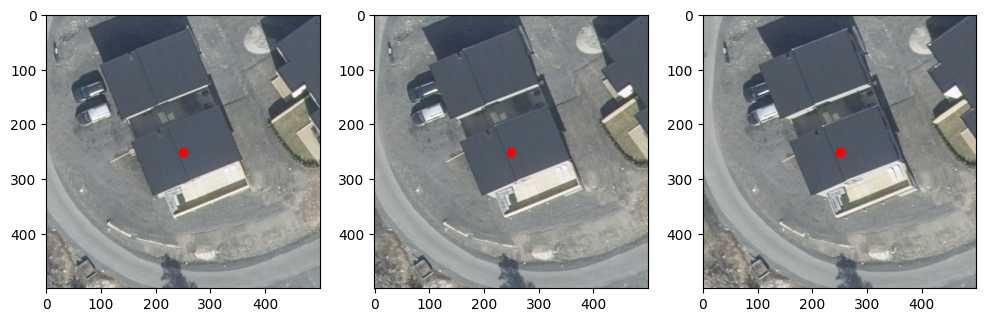

In [9]:
cog_path = '../AgderOst/COG'
plot_matches(matches[60], 500, cog_path)

In [20]:
import rasterio
from rasterio.windows import Window

In [48]:
match_dict = mult_matches[2]
match_dict

{'14583_01_002_20018': ((<POINT (13029.862 5871.241)>,
   <POINT (11104.283 5879.259)>),),
 '14583_01_004_20020': (<POINT (4464.518 5898.666)>,)}

2 2


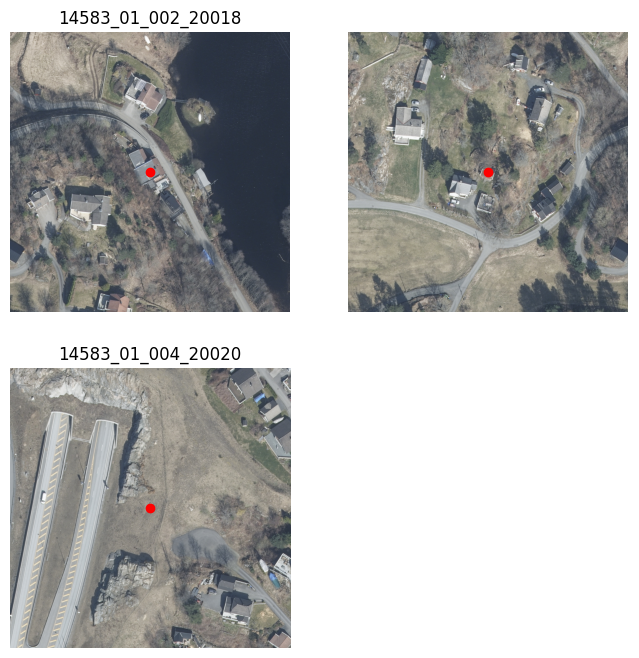

In [ ]:
width=2000
n_rows = len(match_dict)
n_columns = max([len(v[0]) if type(v[0])==tuple else 1 for v in match_dict.values()])
print (n_rows, n_columns)
_, axs = plt.subplots(n_rows, n_columns, figsize=(4*n_columns, 4*n_rows))
for i, iid in enumerate(match_dict):
    axs[i, 0].set_title(iid)
    if type(match_dict[iid][0]) == tuple:
        for j, point in enumerate(match_dict[iid][0]):
            x, y = point.xy
            window = Window(x[0]-width/2, y[0]-width/2, width, width)
            with rasterio.open(f"{cog_path}/{iid}.tif") as src:
                image = src.read(window=window)
                image = np.moveaxis(image, 0, -1)
            axs[i, j].imshow(image)
            axs[i, j].scatter(width/2, width/2, c='red')    
    else:
        x, y = point.xy
        window = Window(x[0]-width/2, y[0]-width/2, width, width)

        with rasterio.open(f"{cog_path}/{iid}.tif") as src:
            image = src.read(window=window)
            image = np.moveaxis(image, 0, -1)

        axs[i, 0].imshow(image)
        axs[i, 0].scatter(width/2, width/2, c='red')    
    for ax in axs[i]:
        ax.axis('off')

In [16]:
match_dict

{'14583_01_001_20017': ((<POINT (4170.555 6521.503)>,
   <POINT (4554.464 6521.569)>),),
 '14583_01_002_20018': (<POINT (807.789 6523.514)>,)}